In [1]:
"""!conda install -c conda-forge --yes --verbose pyopencl pocl"""

'!conda install -c conda-forge --yes --verbose pyopencl pocl'

# I only do OpenCl 

-OpenCl
-Convergence
-Timing
-FEniCS

In [2]:
kernel = """
__kernel void A(const int m,
                const int n,
                const __global double* u,
                const __global double* sigma,
                __global double* product
                            )
                            {
    double result;

    //==== I parallelise in both dimensions
    const int I = get_global_id(0);
    const int J = get_global_id(1);


    //==== Setting the Boundary conditions
    if (I == 0 || I == m-1 || J == 0 || J == n-1) {
            result = u[I*m + J];}
    else {
            double ip; double im; double jp; double jm;
            double alpha;

            ip = 0.5 * (sigma[(I+1)*m + J]+sigma[I*m + J]);
            im = 0.5 *(sigma[(I-1)*m + J]+sigma[I*m + J]);
            jp = 0.5 * (sigma[I*m + J+1] + sigma[I*m + J]);
            jm = 0.5 *(sigma[I*m + J-1] + sigma[I*m + J]);

            alpha = ip + im + jp + jm;

            result = (
                ip*u[(I+1)*m+J]
                + im*u[(I-1)*m+J]
                + jp*u[I*m+J+1]
                + jm*u[I*m+J-1]
                - alpha*u[I*m+J]
            );

        }

    product[I*m +J] = result;
    }
    """

In [3]:
import pyopencl as cl
import numpy as np

from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import bicgstab

import matplotlib.pyplot as plt
from IPython.display import Image
import csv

import time
class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

In [4]:
def sigma_random(N):
    np.random.seed(0)
    S = np.random.normal(0, 0.1, (N+2)*(N+2))
    output = np.array([np.exp(S[N*y + x])  for x in range(N+2) for y in range(N+2)]) 
    return output

def sigma_polynomial(mesh_size):
    x = np.arange(0, 1, 1/mesh_size)
    y = np.arange(0, 1, 1/mesh_size)
    xs, ys = np.meshgrid(x, y)
    return (1 + xs**2 + ys**2).flatten()

def rhs(N):
    output = np.ones((N*N), dtype='float64')
    return -output

In [5]:
def operator_openCl(u, sigma_type="random"):

    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)
    mf = cl.mem_flags
    kernel_src = kernel
    
    mesh_size = int(np.sqrt(np.size(u)))
    m = np.int32(mesh_size)  # rows
    n = np.int32(mesh_size)   # cols

    # Calculate sigma
    if sigma_type == 'random':
        sigma = sigma_random(mesh_size)
    elif sigma_type == 'polynomial':
        sigma = sigma_polynomial(mesh_size)
    else:
        print("Missplling with the sigma type")

    # Upload data to the device
    u_buffer = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=u)
    sigma_buffer = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=sigma)

    # Allocate output buffer
    product_buffer = cl.Buffer(ctx, mf.READ_WRITE, u.nbytes)

    # Build kernel
    tile_size = 1
    global_work_group = (m, n)
    local_work_group = (tile_size, tile_size)
    kernel_args = (m, n, u_buffer, sigma_buffer, product_buffer)
    prg = cl.Program(ctx, kernel_src).build()
    kernel_operator = prg.A

    # Execute kernel on device

    kernel_operator(queue, global_work_group, local_work_group, *kernel_args)

    product = np.empty(m*n, dtype=np.float64)
    cl.enqueue_copy(queue, product, product_buffer)

    return product

In [6]:
# I got help by searching StackOverflow
class gmres_counter(object):
        def __init__(self, F):
            self.niter = 0
            self.residual = []
            self.F = F
        def __call__(self, rk=None):
            self.residual.append(rk)
            self.niter += 1

class bicgstab_counter(object):
        def __init__(self, F, operator):
            self.niter = 0
            self.xks = []
            self.residual = []
            self.F = F
            self.operator = operator
        def __call__(self, xk=None):
            self.xks.append(xk)
            self.niter += 1
            normaliser = np.linalg.norm(self.F)
            self.residual.append(np.linalg.norm(self.F - self.operator(xk))/normaliser)

In [7]:
def Operator_A(N, method, implementation='cl',plot=False,max_iter=100,name=None,part="convergence"):

    u = np.ones((N*N), dtype='float64')
    F = rhs(N)

    if implementation == "cl":
        A = LinearOperator((N*N, N*N), matvec=operator_openCl)
        operator = operator_openCl
    else:
        raise ValueError("I'm only doing opencl here. use cl")
    
    if method=="GMRES":
        if part=="convergence":
            counter = gmres_counter(F)
            u, info = gmres(A, F, maxiter=max_iter, callback=counter) 
        elif part=="time":
            counter = 0
            with Timer() as t:
                u, info = gmres(A, F, maxiter=max_iter)
            counter = t.interval
            
    if method=="BICGSTAB": 
        if part=="convergence":
            counter = bicgstab_counter(F, operator)
            u, info = bicgstab(A, F, maxiter=max_iter, callback=counter)
        elif part=="time":
            counter = 0
            with Timer() as t:
                u, info = bicgstab(A, F, maxiter=max_iter)
            counter = t.interval
    
    if info != 0:
            raise RuntimeError("Faield to converge")
            
    
    u_matrix = np.reshape(u, [N,N])   
        
    if plot == 1:       
        res = 100
        X, Y = np.meshgrid(np.linspace(0, 1, num=N), np.linspace(0, 1, num=N))
        plt.title("PDE solution for method: %s"%(method))
        plt.contourf(X, Y, u_matrix, res)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.colorbar()
        if name != None:
            plt.savefig(name,dpi=90)
        plt.show()
    return counter, u_matrix

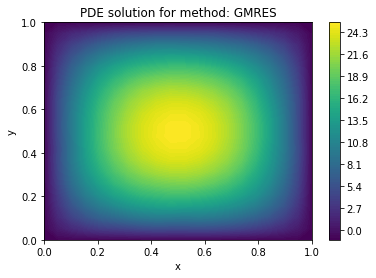

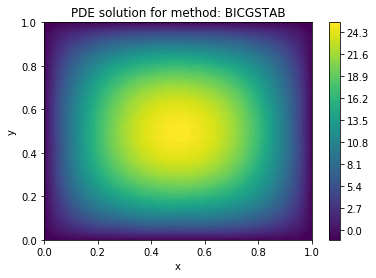

In [8]:
Operator_A(20,'GMRES', plot=True)
Operator_A(20,'BICGSTAB', plot=True);

In [9]:
def convergence(method, max_iter=200, part="residual", N_max = 30):
    N_vec = np.arange(10,N_max+10,10,dtype=int)
    if part=="residual":
        for N in N_vec:
            counter, u = Operator_A(N,method, max_iter = max_iter)
            iterArray = np.linspace(1,counter.niter,counter.niter)
            plt.plot(iterArray,np.log(counter.residual), label="N = {}".format(N))
        plt.title("Convergence rate of method: %s"%(method))
        plt.legend()
        plt.xlabel("iterations")
        plt.ylabel("log (residual)")
        plt.show()
    elif part=="time":
        intervals = []
        for N in N_vec:
            counter, u = Operator_A(N,method, max_iter = max_iter, part="time")
            intervals.append(counter)
        plt.plot(N_vec,intervals)
        plt.title("Timing performance for method: %s"%(method))
        plt.xlabel("mesh size")
        plt.ylabel("time (s)")
        plt.show()

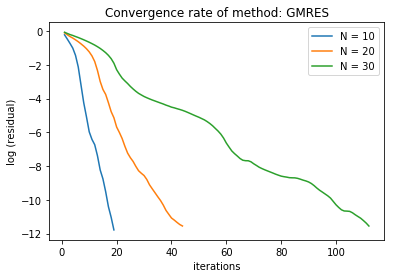

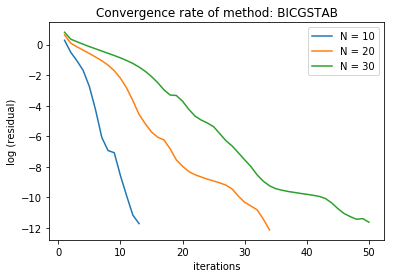

In [10]:
convergence("GMRES")
convergence("BICGSTAB")

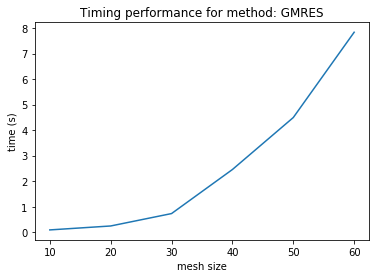

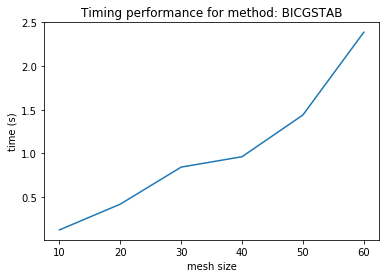

In [11]:
convergence("GMRES",max_iter=400,N_max=60,part="time")
convergence("BICGSTAB",max_iter=400,N_max=60,part="time")

# FEniCS

In [12]:
from dolfin import *
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.tri
from mpl_toolkits.mplot3d import axes3d, Axes3D


def on_boundary(x, on_boundary):
    # Dirichlet Boundary conditions
    return on_boundary


def mesh2triang(mesh):
    #  Mesh -> triangular vertices
    xy = mesh.coordinates()
    return matplotlib.tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())


def run_simulation(mesh_size):
    # Does the experiment for a certain mesh size
    # I use Dirichlet Boundary conditions
    m = mesh_size  
    n = mesh_size  

    mesh = UnitSquareMesh(m, n)
    V = FunctionSpace(mesh, "Lagrange", 1)

    boundary = DirichletBC(V, Constant(0), on_boundary)

    # Using Finite-element for solving
    u = TrialFunction(V)
    v = TestFunction(V)
    f = Constant(1)

    # non-linearitys
    non_linear = Expression("1 + x[0] * x[1] + x[1] * x[1]", element=V.ufl_element())

    a = inner(non_linear*grad(u), grad(v))*dx
    L = f*v*dx

    u = Function(V)
    
    # Sovles it
    solve(a == L, u, boundary)

    return u, mesh


def plot_simulation(mesh_size, dimension):
    """Run and plot simulation"""
    u, mesh = run_simulation(mesh_size)

    C = u.compute_vertex_values(mesh)

    fig = plt.figure()

    if dimension == '3d':
        ax = Axes3D(fig)
        ax.plot_trisurf(mesh2triang(mesh), C, antialiased=True)

    elif dimension == '2d':
        plt.tripcolor(mesh2triang(mesh), C)

    else:
        return "must enter plotting type '2d' or '3d'"

    plt.axis('equal')
    plt.show()


plot_simulation(40, dimension='2d')

ModuleNotFoundError: No module named 'dolfin'